# 04 - Advanced deep-learning best practices

## 04.1 - Monitoreando modelos de Deep Learning usando Keras callbacks y TensorBoard

### 04.1.1 - Callbacks

* **Model checkpointing** : Guarda los pesos actuales del modelo en diferentes puntos del entrenamiento


* **Early stopping**: Interrumpe el entrenamiento cuando el error de validación no mejora (guarda el mejor modelo obtenido en el entrenamiento)


* **Dynamically adjusting the value of certain parameters during training**: Tal como el learning rate del optimizador 


* **Logging training and validation metrics during training, or visualizing the representations
learned by the model as they’re updated** : La barra del progreso de Keras


In [ ]:
import keras
keras.callbacks.ModelCheckpoint
keras.callbacks.EarlyStopping
keras.callbacks.LearningRateScheduler
keras.callbacks.ReduceLROnPlateau
keras.callbacks.CSVLogger

**THE MODELCHECKPOINT AND EARLYSTOPPING CALLBACKS**

* **EarlyStopping callback:** interrumpe el entrenamiento una vez que la metrica a monitorear deja de mejorar para un número fijo de epocas. Permite detener el entrenamiento antes de presentar problemas de overfitting


* **ModelCechpoint**: permite guardr continuamente el modelo durante el entrenamiento (sólo guarda el mejor modelo: el modelo que registra la mejor actuación al final de cada epoca)

In [ ]:
import keras

# Callback se pasa como argumento en la parte del "fit"
# por medio de objeto lista puede pasar cualquier número de callbacks

callbacks_list = [ keras.callbacks.EarlyStopping( monitor='acc', patience=1,), # Interrumpe entrenamiento cuando no hay mejora
                  
                  # monitor -> Monitorea el accuracy de validación del modelo
                  # patience -> Interrumpe el entrenamiento cuando el accuracy no mejora apartir de una epoca
                  
                  keras.callbacks.ModelCheckpoint(filepath='my_model.h5', monitor='val_loss', save_best_only=True,)] # Saves the current weights after every epoch
                # filepath -> Dirrecchion a guardar del modelo
                # monitor & save_best_only ->  Significan que tu no quieres sobre escribir
                # los modelos solo si el error de validación mejora
                # permitiendo guardar solo los mejores modelos durante el entrenamiento.
        

# Si monitoreas accuracy, debe ser parte de tu metrica
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# Note that because the callback will monitor validation loss and validation accuracy, you need to pass validation_data to the call to fit.
model.fit(x, y, epochs=10, batch_size=32, callbacks=callbacks_list, validation_data=(x_val, y_val) )

**THE REDUCELRONPLATEAU CALLBACK**

* Reduce el learnig rate cuando el error de validación no mejora. Es una estrategia efectiva para salir de mínimos locales durante el entrenamiento

In [ ]:
callbacks_list = [
keras.callbacks.ReduceLROnPlateau(
monitor='val_loss' # Monitorea el error de validación del modelo
factor=0.1, # Divide la tasa de aprendizaje por 10 cuando se activa
patience=10, # El callback se activa a partir de que el error de validación deja de 
            # mejorar durante 10 epocas
)
]


model.fit(x, y,
epochs=10,
batch_size=32,
callbacks=callbacks_list,
validation_data=(x_val, y_val))

**Escribiendo tu propio callback**

* Si requieres de una acción en especifico durante el entrenamiento es conveniente construir tu popio callback

In [ ]:
keras.callbacks.Callback

on_epoch_begin # Called at the start of every epoch
on_epoch_end # Called at the end of every epoch
on_batch_begin # Called right before processing each batch
on_batch_end # Called right after processing each batch
on_train_begin # Called at the start of training
on_train_end # Called at the end of training

* Estos métodos son llamados con un argumento logs, el cual es un diccionario que contiene la información respecto a los lotes previos, epocas, o el registro del entrenamiento

Ejemplo: Guardar las capaz de activación del modelo al final de cada epoca, esto solo para el primer sample del conjunto de validación

In [ ]:
import keras
import numpy as np

class ActivationLogger(keras.callbacks.Callback):
    # Called by the parent model before training, to inform the callback of what model will be calling it
    def set_model(self, model):
        self.model = model
        layer_outputs = [layer.output for layer in model.layers]
        self.activations_model = keras.models.Model(model.input,layer_outputs)
    # Model instance that returns the activations of every layer    
    def on_epoch_end(self, epoch, logs=None):
        if self.validation_data is None:
            raise RuntimeError('Requires validation_data.')
            
    validation_sample = self.validation_data[0][0:1] # Obtains the first input sample of the validation data
    activations = self.activations_model.predict(validation_sample)
    f = open('activations_at_epoch_' + str(epoch) + '.npz', 'w') # Saves arrays to disk
    np.savez(f, activations)
    f.close()

### 04.1. - TensorBoard

Herramienta de visualización de Tensorflow

* Visualiza el monitoreo de las métricas durante el entrenamiento

* Visualiza la arquitectura del modelo

* Visualiza histogramas de activación y gradiente

* Explora embedding en 3D

Ejemplo: Clasificación de Texto con TensorBoard

Datos -> IMDB data análisis de sentimientos

In [4]:
import keras
from keras import layers
from keras.datasets import imdb
from keras.preprocessing import sequence
import numpy as np

max_features = 2000
max_len = 500

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# Loads the data as lists of integers
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
# importando los datos como una secuencia de números, índices


# restore np.load for future normal usage
np.load = np_load_old

x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
model = keras.models.Sequential()
model.add(layers.Embedding(max_features, 128,
input_length=max_len,
name='embed'))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, 500, 128)          256000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 291,937
Trainable params: 291,937
Non-trainable params: 0
_________________________________________________________________


Crear dir:

* mkdir my_log_dir


In [ ]:
import keras 
callbacks = [keras.callbacks.TensorBoard(
    log_dir = 'taller_keras',
    histogram_freq = 1,
    embeddings_freq = 1,
    embeddings_data = test, # esto yo se lo puse
)]

history = model.fit(train, label_train,
epochs=1,
batch_size=128,
validation_split=0.2,
callbacks=callbacks)

Escribir:

tensorboard --logdir=my_log_dir

ir a: 

http://localhost:6006

Otra manera de visualizar el modelo:

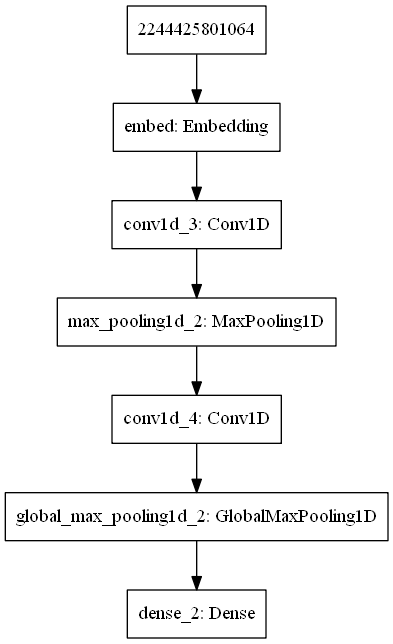

In [5]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

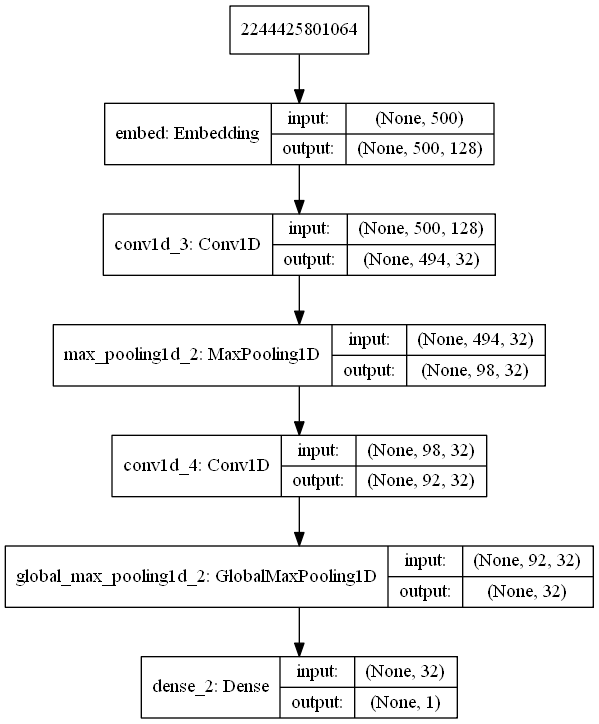

In [6]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

## 04.2 - Arquitecturas  avanzadas

### 04.2.1 -  Batch Normalization

Es una capa que normaliza datos incluso si la media y varianza de los datos cambian durante el entrenamiento. Ayuda en mejorar el problema de saturación.

* Muestras diferentes a algo más simmilar

* Generaliza mejor los nuevos datos



normalized_data = (data - np.mean(data, axis=...)) / np.std(data, axis=...)

* Se utiliza usualmente seguido de una capa densa o convolucionañ

In [ ]:
conv_model.add(layers.Conv2D(32, 3, activation='relu')) # After a Conv layer
conv_model.add(layers.BatchNormalization())


dense_model.add(layers.Dense(32, activation='relu')) # After a Dense layer
dense_model.add(layers.BatchNormalization())

### 04.2.2 -   DEPTHWISE SEPARABLE CONVOLUTION

* Depthwise

* Pointwise

Genera modelos más ligeros (menos pesos) y más rápidos con mejora en el desempeño.

La capa realiza una convoluciónespacial para cada canal de entrada, de forma independiente, despues realiza un mixing a los canales de salida por medio de un poinwise convolution (un convolution filtes de tamaño $1 x 1$)

In [8]:
from keras.models import Sequential, Model
from keras import layers

height = 64
width = 64
channels = 3
num_classes = 10

model = Sequential()
model.add(layers.SeparableConv2D(32, 3, activation='relu', input_shape=(height, width, channels,)))

model.add(layers.SeparableConv2D(64, 3, activation='relu'))

model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(64, 3, activation='relu'))

model.add(layers.SeparableConv2D(128, 3, activation='relu'))

model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(64, 3, activation='relu'))

model.add(layers.SeparableConv2D(128, 3, activation='relu'))

model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 62, 62, 32)        155       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 60, 60, 64)        2400      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 28, 28, 64)        4736      
_________________________________________________________________
separable_conv2d_4 (Separabl (None, 26, 26, 128)       8896      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
separable_conv2d_5 (Separabl (None, 11, 11, 64)        9408      
__________

Visualización del modelo

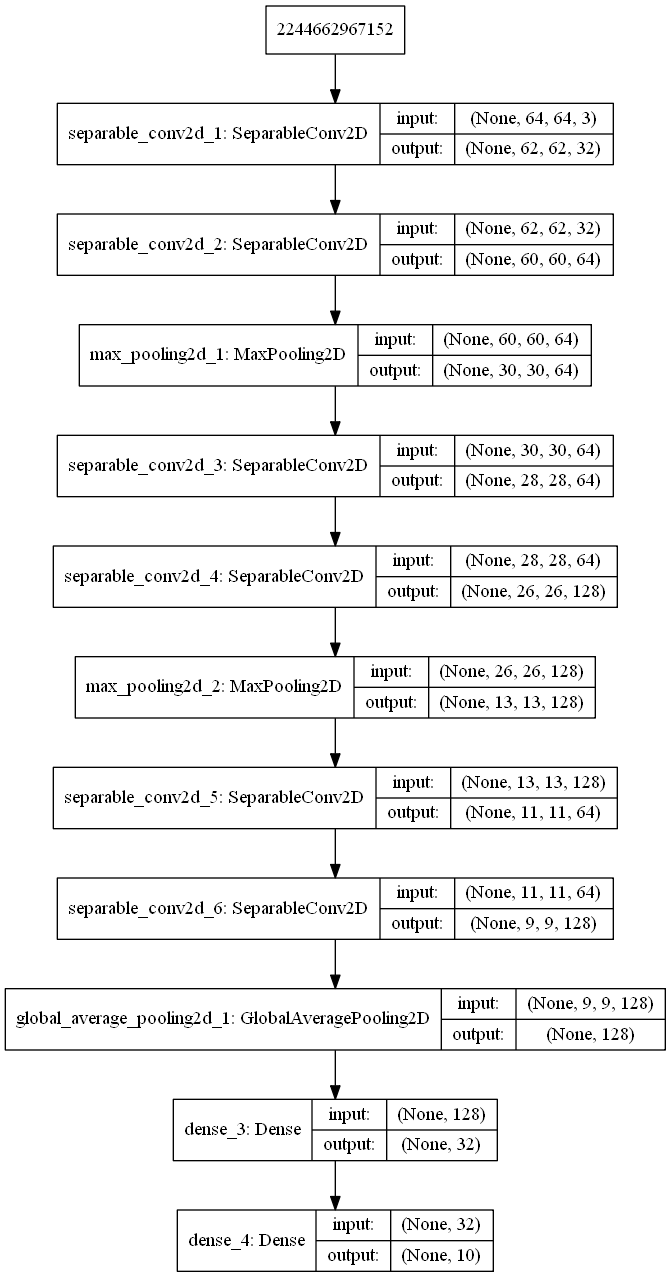

In [9]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='deepthwise.png')
from IPython.display import Image
Image(retina=True, filename='deepthwise.png')

## 04.3 -  Optimización de Hyperparametros

Hyperopt (https://github.com/hyperopt/hyperopt)

Hyperas (https://github.com/maxpumperla/hyperas)
integra Hyperopt para utilizar con los modelos de Keras

## 04.4 -  Ensamblado de modelos

Se basa en realiza un pooling de las predicciónde de diferentes modelos, con el fin de mejorar la predicción 

* Trabaja bajo el supuesto de que a diferentes modelos, entrenados de manera diferente, son mejores por distintas razones: cada modelo captira diferencias en la predicción de los datos, obteniendo parte de la verdad en cada uno de ellos.

Una manera de juntar la predicción es; promediando las predicciones.

* Esto solo funciona si los clasificadore son casi igual de buenos

preds_a = model_a.predict(x_val)
preds_b = model_b.predict(x_val)
preds_c = model_c.predict(x_val)
preds_d = model_d.predict(x_val)


final_preds = 0.25 * (preds_a + preds_b + preds_c + preds_d)



Otra manera de ensamblarlos es con un promedio ponderado, donde los pesos se pueden aprender. A mejor el clasificador mayor peso

preds_a = model_a.predict(x_val)
preds_b = model_b.predict(x_val)
preds_c = model_c.predict(x_val)
preds_d = model_d.predict(x_val)


final_preds = 0.5 * preds_a + 0.25 * preds_b + 0.1 * preds_c + 0.15 * preds_d

La clave del ensamble es tener clasificadores moderadamente buenos, o buenos, pero que cada uno sea distinto entre si.

### 4.2 Regularización  weight decay L1 (Lasso)  y L2 (Ridge)

* Norma L1

In [ ]:
from keras import regularizers

kernel_regularizer=regularizers.l1(0.001)

# En el modelo

model_input = Input(shape = (28*28,))
x = Dense(16, kernel_regularizer=regularizers.l1(0.001), activation = "relu")(model_input)
x = Dense(16, kernel_regularizer=regularizers.l1(0.001), activation = "relu")(x)
model_output = Dense(10, activation ="softmax")(x)

* Norma L2

In [ ]:
from keras import regularizers

kernel_regularizer=regularizers.l2(0.001)

# En el modelo

model_input = Input(shape = (28*28,))
x = Dense(16, kernel_regularizer=regularizers.l2(0.001), activation = "relu")(model_input)
x = Dense(16, kernel_regularizer=regularizers.l2(0.001), activation = "relu")(x)
model_output = Dense(10, activation ="softmax")(x)

### 4.3 Drop out

In [ ]:
from keras.layers import Dropout

Dropout(.5)

# En el modelo

model_input = Input(shape = (28*28,))
x = Dense(16,  activation = "relu")(model_input)
x = Dropout(.5)(x)
x = Dense(16,  activation = "relu")(x)
x = Dropout(.5)(x)
model_output = Dense(10, activation ="softmax")(x)



### Ejercicio 1. Regularización

In [1]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Using TensorFlow backend.
C:\Users\h_air\.julia\conda\3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\h_air\.julia\conda\3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\h_air\.julia\conda\3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\h_air\.julia\conda\3\lib\site-packages\tensorflow\python

In [2]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

In [3]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

### 1.1 - Regularización en los pesos con norma L1

In [17]:
from keras import regularizers
from keras import Input
from keras.layers import Dense
from keras import Model

l1_model_input = Input(shape = (28*28,))
x = Dense(16, kernel_regularizer=regularizers.l1(0.001), activation = "relu")(l1_model_input)
x = Dense(16, kernel_regularizer=regularizers.l1(0.001), activation = "relu")(x)
l1_model_output = Dense(10, activation ="softmax")(x)

model_l1 = Model(l1_model_input, l1_model_output)

model_l1.summary()


model_l1.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])




Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                12560     
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


In [18]:
import time
tic=time.time()

history_l1 = model_l1.fit(train_images, train_labels, epochs=5, batch_size=128, 
                 validation_split=0.2)
print('Tiempo de procesamiento (secs): ', time.time()-tic)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 2s 38us/step - loss: 1.1378 - acc: 0.7744 - val_loss: 0.7124 - val_acc: 0.8857
Epoch 2/5
48000/48000 [==============================] - 2s 35us/step - loss: 0.6738 - acc: 0.8894 - val_loss: 0.6027 - val_acc: 0.9062
Epoch 3/5
48000/48000 [==============================] - 1s 27us/step - loss: 0.6010 - acc: 0.9031 - val_loss: 0.5580 - val_acc: 0.9134
Epoch 4/5
48000/48000 [==============================] - 1s 24us/step - loss: 0.5625 - acc: 0.9088 - val_loss: 0.5286 - val_acc: 0.9172
Epoch 5/5
48000/48000 [==============================] - 1s 24us/step - loss: 0.5372 - acc: 0.9123 - val_loss: 0.5343 - val_acc: 0.9084
Tiempo de procesamiento (secs):  7.271017789840698


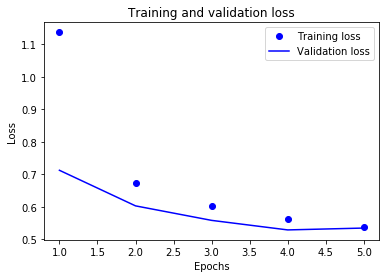

In [21]:
import matplotlib.pyplot as plt

acc = history_l1.history['acc']
val_acc = history_l1.history['val_acc']
loss = history_l1.history['loss']
val_loss = history_l1.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [22]:
test_loss, test_acc = model_l1.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

10000/10000 [==============================] - 1s 59us/step
test_acc: 0.9081


### 1.2 - Regularización en los pesos con norma L2

In [28]:
l2_model_input = Input(shape = (28*28,))
x = Dense(16, kernel_regularizer=regularizers.l2(0.001), activation = "relu")(l2_model_input)
x = Dense(16, kernel_regularizer=regularizers.l2(0.001), activation = "relu")(x)
l2_model_output = Dense(10, activation ="softmax")(x)

model_l2 = Model(l2_model_input, l2_model_output)

model_l2.summary()


model_l2.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                12560     
_________________________________________________________________
dense_19 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_20 (Dense)             (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


In [29]:
import time
tic=time.time()

history_l2 = model_l2.fit(train_images, train_labels, epochs=5, batch_size=128, 
                 validation_split=0.2)
print('Tiempo de procesamiento (secs): ', time.time()-tic)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 2s 39us/step - loss: 0.8315 - acc: 0.7844 - val_loss: 0.4343 - val_acc: 0.8937
Epoch 2/5
48000/48000 [==============================] - 1s 27us/step - loss: 0.4012 - acc: 0.9072 - val_loss: 0.3540 - val_acc: 0.9202
Epoch 3/5
48000/48000 [==============================] - 1s 26us/step - loss: 0.3551 - acc: 0.9190 - val_loss: 0.3332 - val_acc: 0.9232
Epoch 4/5
48000/48000 [==============================] - 1s 27us/step - loss: 0.3334 - acc: 0.9240 - val_loss: 0.3139 - val_acc: 0.9305
Epoch 5/5
48000/48000 [==============================] - 1s 30us/step - loss: 0.3174 - acc: 0.9293 - val_loss: 0.2999 - val_acc: 0.9354
Tiempo de procesamiento (secs):  7.286818981170654


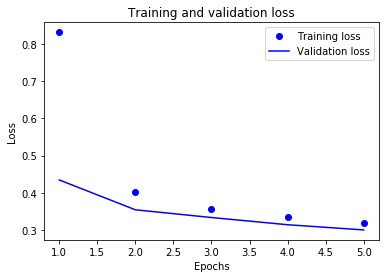

In [30]:
acc = history_l2.history['acc']
val_acc = history_l2.history['val_acc']
loss = history_l2.history['loss']
val_loss = history_l2.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [31]:
test_loss, test_acc = model_l2.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

10000/10000 [==============================] - 0s 35us/step
test_acc: 0.9332


### 1.3 Regularización Drop out

In [38]:
from keras.layers import Dropout

model_dropOut_in = Input(shape = (28*28,))
x = Dense(16,  activation = "relu")(model_dropOut_in)
x = Dropout(.5)(x)
x = Dense(16,  activation = "relu")(x)
x = Dropout(.5)(x)
lmodel_dropOut_out = Dense(10, activation ="softmax")(x)

model_dropOut = Model(model_dropOut_in, lmodel_dropOut_out)

model_dropOut.summary()


model_dropOut.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])


import time
tic=time.time()

history_dropOut = model_dropOut.fit(train_images, train_labels, epochs=5, batch_size=128, 
                 validation_split=0.2)
print('Tiempo de procesamiento (secs): ', time.time()-tic)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 16)                12560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
______________________________________________________

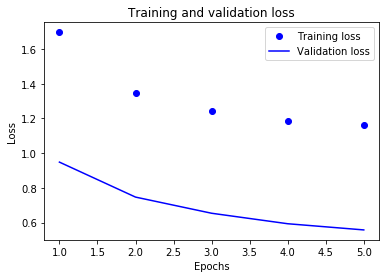

In [39]:
acc = history_dropOut.history['acc']
val_acc = history_dropOut.history['val_acc']
loss = history_dropOut.history['loss']
val_loss = history_dropOut.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [41]:
test_loss, test_acc = model_dropOut.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

10000/10000 [==============================] - 0s 34us/step
test_acc: 0.8795


### 1.4 Callbacks Early stopping

In [49]:
from keras.layers import Dropout

entrada = Input(shape = (28*28,))
x = Dense(16,  activation = "relu")(entrada)
x = Dense(16,  activation = "relu")(x)
salida = Dense(10, activation ="softmax")(x)

modelo = Model(entrada, salida)

modelo.summary()




Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 16)                12560     
_________________________________________________________________
dense_34 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_35 (Dense)             (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


In [50]:
import time
import keras

callbacks_list = [ keras.callbacks.EarlyStopping( monitor='acc', patience=1,),                 
                  keras.callbacks.ModelCheckpoint(filepath='my_model.h5', monitor='val_loss', save_best_only=True,)] 

modelo.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])


tic=time.time()

historia = modelo.fit(train_images, train_labels, epochs=75, batch_size=128, callbacks=callbacks_list, validation_split=0.2 )

print('Tiempo de procesamiento (secs): ', time.time()-tic)

Train on 48000 samples, validate on 12000 samples
Epoch 1/75
48000/48000 [==============================] - 2s 41us/step - loss: 0.1105 - acc: 0.9618 - val_loss: 0.0528 - val_acc: 0.9827
Epoch 2/75
48000/48000 [==============================] - 1s 26us/step - loss: 0.0508 - acc: 0.9835 - val_loss: 0.0445 - val_acc: 0.9852
Epoch 3/75
48000/48000 [==============================] - 1s 25us/step - loss: 0.0441 - acc: 0.9854 - val_loss: 0.0402 - val_acc: 0.9868
Epoch 4/75
48000/48000 [==============================] - 1s 27us/step - loss: 0.0405 - acc: 0.9867 - val_loss: 0.0381 - val_acc: 0.9874
Epoch 5/75
48000/48000 [==============================] - 2s 33us/step - loss: 0.0377 - acc: 0.9877 - val_loss: 0.0366 - val_acc: 0.9878
Epoch 6/75
48000/48000 [==============================] - 1s 30us/step - loss: 0.0355 - acc: 0.9884 - val_loss: 0.0353 - val_acc: 0.9885
Epoch 7/75
48000/48000 [==============================] - 1s 25us/step - loss: 0.0338 - acc: 0.9889 - val_loss: 0.0342 - val_acc

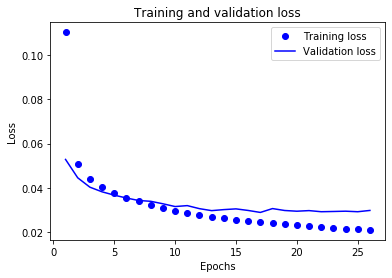

In [51]:
acc = historia.history['acc']
val_acc = historia.history['val_acc']
loss = historia.history['loss']
val_loss = historia.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [52]:
test_loss, test_acc = modelo.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

10000/10000 [==============================] - 0s 35us/step
test_acc: 0.990899998664856


* Se observa el número de epoca en el cual se detiene el entrenamiento

In [60]:
epoca = len(historia.epoch) # epoca seleccionada
print(epoca)

26


* Eliminamos el modelo y entrenamos con el número de epoca obtenida 

In [56]:
del modelo

In [58]:
from keras.layers import Dropout

entrada = Input(shape = (28*28,))
x = Dense(16,  activation = "relu")(entrada)
x = Dense(16,  activation = "relu")(x)
salida = Dense(10, activation ="softmax")(x)

modelo = Model(entrada, salida)

modelo.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 16)                12560     
_________________________________________________________________
dense_37 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_38 (Dense)             (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


In [59]:
import time

modelo.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])


tic=time.time()

historia = modelo.fit(train_images, train_labels, epochs= epoca, batch_size=128, validation_split=0.2 )

print('Tiempo de procesamiento (secs): ', time.time()-tic)

Train on 48000 samples, validate on 12000 samples
Epoch 1/26
48000/48000 [==============================] - 2s 41us/step - loss: 0.1163 - acc: 0.9593 - val_loss: 0.0576 - val_acc: 0.9816
Epoch 2/26
48000/48000 [==============================] - 1s 26us/step - loss: 0.0531 - acc: 0.9828 - val_loss: 0.0445 - val_acc: 0.9853
Epoch 3/26
48000/48000 [==============================] - 1s 29us/step - loss: 0.0441 - acc: 0.9856 - val_loss: 0.0407 - val_acc: 0.9864
Epoch 4/26
48000/48000 [==============================] - 1s 27us/step - loss: 0.0396 - acc: 0.9872 - val_loss: 0.0379 - val_acc: 0.9873
Epoch 5/26
48000/48000 [==============================] - 1s 27us/step - loss: 0.0367 - acc: 0.9881 - val_loss: 0.0361 - val_acc: 0.9883
Epoch 6/26
48000/48000 [==============================] - 1s 26us/step - loss: 0.0347 - acc: 0.9886 - val_loss: 0.0350 - val_acc: 0.9887
Epoch 7/26
48000/48000 [==============================] - 1s 29us/step - loss: 0.0332 - acc: 0.9893 - val_loss: 0.0334 - val_acc

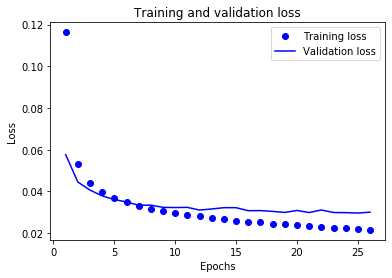

In [61]:
acc = historia.history['acc']
val_acc = historia.history['val_acc']
loss = historia.history['loss']
val_loss = historia.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [62]:
test_loss, test_acc = modelo.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

10000/10000 [==============================] - 1s 63us/step
test_acc: 0.9905500003814697
